In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline

/Users/srikanajan/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Walmart Sales Data

For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week


#### Loading the data and setting the DateTimeIndex

In [2]:
data = pd.read_csv('../../assets/dataset/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [3]:
# Filter to store 1 sales and average over weeks
store1_sales = data[data.Store == 1][['Weekly_Sales']].resample('W', 'sum')
store1_sales.head()

/Users/srikanajan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

/Users/srikanajan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=3,center=False).mean()
  """Entry point for launching an IPython kernel.


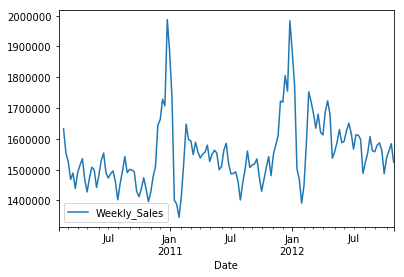

In [4]:
pd.rolling_mean(store1_sales[['Weekly_Sales']], 3).plot()

#### Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.

In [5]:
print('Autocorrelation 1: ', store1_sales['Weekly_Sales'].autocorr(1))
print('Autocorrelation 3: ', store1_sales['Weekly_Sales'].autocorr(3))
print('Autocorrelation 52: ', store1_sales['Weekly_Sales'].autocorr(52))

('Autocorrelation 1: ', 0.30215827941131262)
('Autocorrelation 3: ', 0.059799235066717006)
('Autocorrelation 52: ', 0.89537602947770079)


/Users/srikanajan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


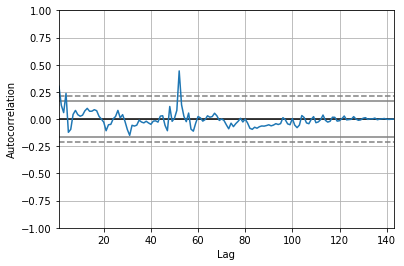

In [6]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1_sales['Weekly_Sales'])

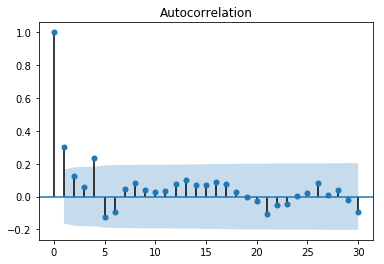

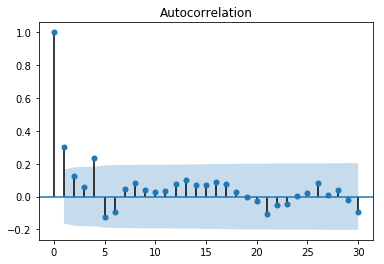

In [7]:
plot_acf(store1_sales['Weekly_Sales'],lags=30)


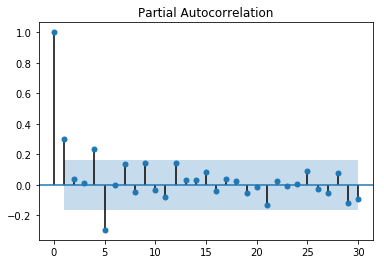

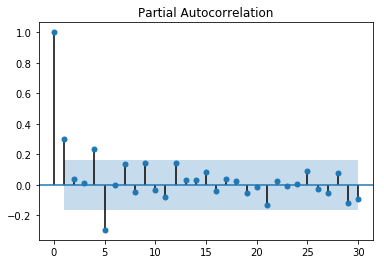

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(store1_sales['Weekly_Sales'],lags=30)


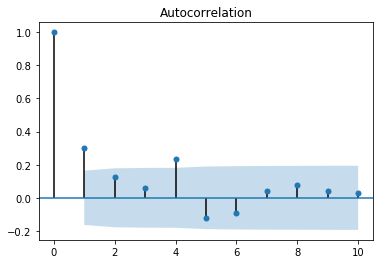

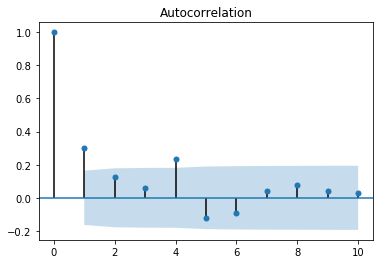

In [9]:


plot_acf(store1_sales['Weekly_Sales'], lags=10)

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

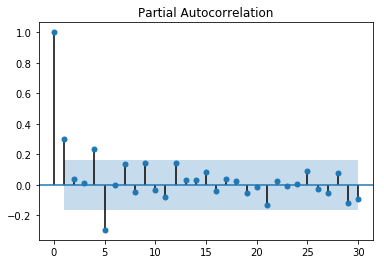

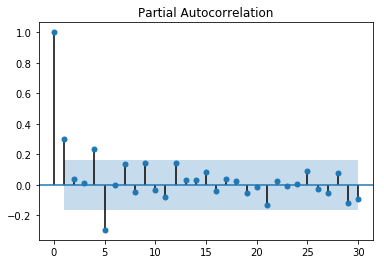

In [10]:
plot_pacf(store1_sales['Weekly_Sales'], lags=30)


#### Split the weekly sales data in a training and test set - using 75% of the data for training

In [11]:
store1_sales.sort_index(inplace=True)

In [12]:
n = len(store1_sales.Weekly_Sales)

train = store1_sales.Weekly_Sales[:int(.75*n)]
test = store1_sales.Weekly_Sales[int(.75*n):]

In [13]:
print train.index.min()
print train.index.max()

2010-02-07 00:00:00
2012-02-19 00:00:00


#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [14]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [15]:
model = sm.tsa.ARIMA(train, (1, 0, 0)).fit()

predictions = model.predict(
    '2012-02-26',
    '2012-10-28',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81839.338631623992)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(1, 0)   Log Likelihood               -1434.663
Method:                       css-mle   S.D. of innovations         160916.939
Date:                Thu, 16 Nov 2017   AIC                           2875.327
Time:                        09:05:59   BIC                           2883.345
Sample:                    02-07-2010   HQIC                          2878.577
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   2.26e+04     68.293      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.3147      0.093      3.399      0.001       0.133       0.496
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1779           +0.0000j            3.1779            0.0000
-----------------------------------------------------------------------------
"""

#### Plot the residuals - where are their significant errors.

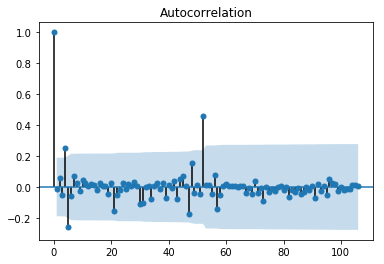

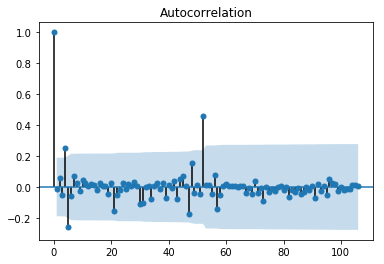

In [16]:
plot_acf(model.resid)

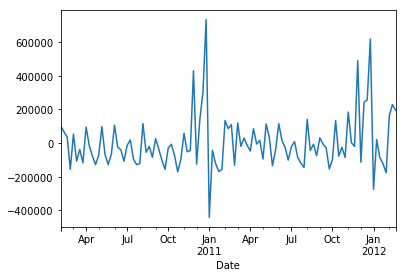

In [17]:
model.resid.plot()

#### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [18]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81203.234373150481)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Thu, 16 Nov 2017   AIC                           2876.963
Time:                        09:05:59   BIC                           2887.655
Sample:                    02-07-2010   HQIC                          2881.298
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06    2.4e+04     64.349      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.2974      0.097      3.075      0.003       0.108       0.487
ar.L2.Weekly_Sales     0.0589      0.098      0.603      0.548      -0.132       0.250
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3080           +0.0000j            2.3080            0.0000
AR.2           -7.3587           +0.0000j            7.3587            0.5000
-----------------------------------------------------------------------------
"""

In [19]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 80502.761843172528)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144113.438
Date:                Thu, 16 Nov 2017   AIC                           2863.563
Time:                        09:06:00   BIC                           2879.600
Sample:                    02-07-2010   HQIC                          2870.064
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   1.92e+04     80.317      0.000    1.51e+06    1.58e+06
ar.L1.Weekly_Sales    -1.0397      0.090    -11.582      0.000      -1.216      -0.864
ar.L2.Weekly_Sales    -0.4700      0.087     -5.379      0.000      -0.641      -0.299
ma.L1.Weekly_Sales     1.4691      0.058     25.350      0.000       1.356       1.583
ma.L2.Weekly_Sales     0.9998      0.074     13.532      0.000       0.855       1.145
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1060           -0.9509j            1.4586           -0.3870
AR.2           -1.1060           +0.9509j            1.4586            0.3870
MA.1           -0.7347           -0.6785j            1.0001           -0.3813
MA.2           -0.7347           +0.6785j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [20]:
model = sm.tsa.ARIMA(train, (0, 0, 4)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=False)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 75454.322199075279)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(0, 4)   Log Likelihood               -1424.991
Method:                       css-mle   S.D. of innovations         145902.231
Date:                Thu, 16 Nov 2017   AIC                           2861.982
Time:                        09:06:00   BIC                           2878.019
Sample:                    02-07-2010   HQIC                          2868.484
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   3.16e+04     48.818      0.000    1.48e+06    1.61e+06
ma.L1.Weekly_Sales     0.4790      0.086      5.575      0.000       0.311       0.647
ma.L2.Weekly_Sales     0.3060      0.118      2.603      0.011       0.076       0.536
ma.L3.Weekly_Sales     0.0247      0.130      0.190      0.850      -0.230       0.279
ma.L4.Weekly_Sales     0.4578      0.107      4.279      0.000       0.248       0.668
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.7807           -0.7663j            1.0939           -0.3765
MA.2           -0.7807           +0.7663j            1.0939            0.3765
MA.3            0.7537           -1.1213j            1.3511           -0.1558
MA.4            0.7537           +1.1213j            1.3511            0.1558
-----------------------------------------------------------------------------
"""